# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import re

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("AZDIAS subset:")
print("Rows, columns:", azdias.shape)
print(azdias.info())
display(azdias.head())
print("\nFeature summary:")
print("Rows, columns:", feat_info.shape)
print(feat_info.info())
display(feat_info.head())

AZDIAS subset:
Rows, columns: (891221, 85)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64 

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0



Feature summary:
Rows, columns: (85, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB
None


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# identify naturally missing data (nulls) in azdias
nulls = azdias.isna().sum().sum()
print("azdias - null values total:", nulls)

azdias - null values total: 4896838


In [5]:
# identify what the 'missing' or 'unknown' values codes are in feat_info
# these are in the 4th column (missing_or_unknown)
print(feat_info['missing_or_unknown'].head())

# convert missing_or_unknown value strings to lists of values
feat_info['missing_or_unknown_list'] = feat_info.missing_or_unknown.apply(lambda x: x[1:-1].split(','))

# check the first row's list values
print("Check row 0 values:", feat_info['missing_or_unknown_list'][0][0], feat_info['missing_or_unknown_list'][0][1])

0      [-1,0]
1    [-1,0,9]
2      [-1,0]
3         [0]
4        [-1]
Name: missing_or_unknown, dtype: object
Check row 0 values: -1 0


In [6]:
# feat_info attribute column lists all column names from azdias
# feat_info missing_or_unknown column lists the missing/unknown  
#  value corresponding to the same column in azdias  
print("azdias:")
display(azdias.head(1))
print("feat_info:")
display(feat_info.head(1)) 

azdias:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


feat_info:


,attribute,information_level,type,missing_or_unknown,missing_or_unknown_list
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"


**Identify 'missing' or 'unknown' value codes in azdias**   
- ie columns that have one of the missing_or_unknown_list values in feat_info  
- look for the column name from azdias in the attribute row value from feat_info  

In [7]:
# convert azdias 'missing' or 'unknown' value codes into NaN
# ie where value in missing_or_unknown_list change value to NaN 

for i in range(len(feat_info)):
    # using regex to extract the digits
    missing_data = re.sub('[\[|\]]', '',feat_info.iloc[i]['missing_or_unknown']).split(',')
    # return the digit values for integer strings only
    if missing_data != ['']:
        missing_data = [np.int64(data) if (data!='X' and data!='XX') else data for data in missing_data]
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_data}, np.nan)
        
display(azdias.head())   

# identify naturally missing data (nulls) in azdias
nulls = azdias.isna().sum().sum()
print(">> azdias - null values total:", nulls)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


>> azdias - null values total: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the dataset.

# find count of nulsl and total values per column
nulls =  pd.DataFrame(azdias.isna().sum(), columns=['null_cnt'])
nulls['ttl'] = len(azdias)
nulls['null_pct'] = nulls['null_cnt'] / nulls['ttl']

print(">> azdias - null values per column:")
display(nulls.sort_values(by='null_cnt', ascending=False))

>> azdias - null values per column:


,null_cnt,ttl,null_pct
TITEL_KZ,889061,891221,0.997576
AGER_TYP,685843,891221,0.769554
KK_KUNDENTYP,584612,891221,0.655967
KBA05_BAUMAX,476524,891221,0.534687
GEBURTSJAHR,392318,891221,0.440203
...,...,...,...
SEMIO_RAT,0,891221,0.000000
SEMIO_KRIT,0,891221,0.000000
SEMIO_DOM,0,891221,0.000000
SEMIO_TRADV,0,891221,0.000000


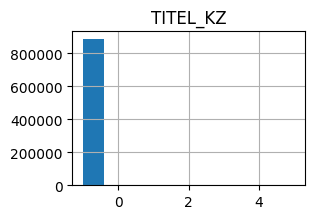

In [9]:
# plot the column with the most nulls

plt.figure(figsize=(3,2))
plt.title('TITEL_KZ')
azdias['TITEL_KZ'].fillna(-1).hist();

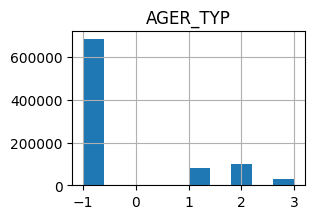

In [10]:
# plot the column with the 2nd most nulls

plt.figure(figsize=(3,2))
plt.title('AGER_TYP')
azdias['AGER_TYP'].fillna(-1).hist();

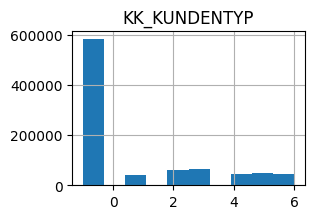

In [11]:
# plot the column with the 3rd most nulls

plt.figure(figsize=(3,2))
plt.title('KK_KUNDENTYP')
azdias['KK_KUNDENTYP'].fillna(-1).hist();

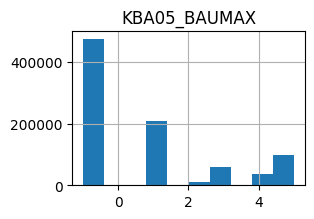

In [12]:
# plot the column with the 4th most nulls

plt.figure(figsize=(3,2))
plt.title('KBA05_BAUMAX')
azdias['KBA05_BAUMAX'].fillna(-1).hist();

In [13]:
# Investigate patterns in the amount of missing data in each column.

display(nulls[nulls['null_pct'] > 0.20].sort_values(by='null_cnt', ascending=False))

,null_cnt,ttl,null_pct
TITEL_KZ,889061,891221,0.997576
AGER_TYP,685843,891221,0.769554
KK_KUNDENTYP,584612,891221,0.655967
KBA05_BAUMAX,476524,891221,0.534687
GEBURTSJAHR,392318,891221,0.440203
ALTER_HH,310267,891221,0.348137


In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# remove columns missing > 20% of data 
azdias = azdias.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'], axis=1)
display(azdias.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [15]:
with pd.option_context('display.max_rows', None,):
    print(nulls[nulls['null_cnt'] > 0].sort_values(by='null_cnt', ascending=False))

                       null_cnt     ttl  null_pct
TITEL_KZ                 889061  891221  0.997576
AGER_TYP                 685843  891221  0.769554
KK_KUNDENTYP             584612  891221  0.655967
KBA05_BAUMAX             476524  891221  0.534687
GEBURTSJAHR              392318  891221  0.440203
ALTER_HH                 310267  891221  0.348137
KKK                      158064  891221  0.177357
REGIOTYP                 158064  891221  0.177357
W_KEIT_KIND_HH           147988  891221  0.166051
KBA05_ANTG3              133324  891221  0.149597
KBA05_ANTG1              133324  891221  0.149597
KBA05_ANTG2              133324  891221  0.149597
KBA05_GBZ                133324  891221  0.149597
KBA05_ANTG4              133324  891221  0.149597
MOBI_REGIO               133324  891221  0.149597
PLZ8_ANTG2               116515  891221  0.130736
PLZ8_ANTG1               116515  891221  0.130736
PLZ8_ANTG3               116515  891221  0.130736
PLZ8_ANTG4               116515  891221  0.130736


#### Discussion 1.1.2: Assess Missing Data in Each Column  
(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. 

***
> Response:  

> These columns appear to be related because they are missing the exact same count of data:   
> - 133,324 nulls, 15%: KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_GBZ, KBA05_ANTG4, MOBI_REGIO  
> - 158,064 nulls, 18%: KKK, REGIOTYP   
> - 116,515 nulls, 13%: PLZ8_ANTG4, PLZ8_HHZ, PLZ8_GBZ, PLZ8_BAUMAX, PLZ8_ANTG3, PLZ8_ANTG2, PLZ8_ANTG1  
> - 111,196 nulls, 12%: VERS_TYP, SHOPPER_TYP, HEALTH_TYP

> The following columns were removed from the dataset because they have > 20% missing values:  
> - 'TITEL_KZ'
> - 'AGER_TYP'
> - 'KK_KUNDENTYP'
> - 'KBA05_BAUMAX'  
> - 'GEBURTSJAHR'
> - 'ALTER_HH'
***



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?

# find count of null and total values per row
nulls_row =  pd.DataFrame(azdias.isna().sum(axis=1), columns=['null_row_cnt'])
nulls_row['ttl'] = azdias.shape[1]
nulls_row['null_row_pct'] = nulls_row['null_row_cnt'] / nulls_row['ttl']
display(nulls_row.head())

print(">> azdias - sorted null values per row:")
display(nulls_row.sort_values(by='null_row_cnt', ascending=False))


,null_row_cnt,ttl,null_row_pct
0,43,79,0.544304
1,0,79,0.000000
2,0,79,0.000000
3,7,79,0.088608
4,0,79,0.000000


>> azdias - sorted null values per row:


,null_row_cnt,ttl,null_row_pct
732775,49,79,0.620253
643174,49,79,0.620253
472919,48,79,0.607595
345274,47,79,0.594937
299868,47,79,0.594937
...,...,...,...
349047,0,79,0.000000
349048,0,79,0.000000
349049,0,79,0.000000
349050,0,79,0.000000


In [17]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

subset_threshold_row = 0.30

# rows missing < threshold
nulls_row_less_threshold = nulls_row[nulls_row['null_row_pct'] < subset_threshold_row]
print(">> Subset for Missing <", subset_threshold_row*100, "% - row count:", nulls_row_less_threshold.shape[0])
display(nulls_row_less_threshold.head())

# rows missing >= threshold
nulls_row_threshold_plus = nulls_row[nulls_row['null_row_pct'] >= subset_threshold_row]
print(">> Subset for Missing >=", subset_threshold_row*100, "% - row count:" , nulls_row_threshold_plus.shape[0])
display(nulls_row_threshold_plus.head())


>> Subset for Missing < 30.0 % - row count: 797837


,null_row_cnt,ttl,null_row_pct
1,0,79,0.000000
2,0,79,0.000000
3,7,79,0.088608
4,0,79,0.000000
5,0,79,0.000000


>> Subset for Missing >= 30.0 % - row count: 93384


,null_row_cnt,ttl,null_row_pct
0,43,79,0.544304
11,47,79,0.594937
14,47,79,0.594937
17,47,79,0.594937
24,47,79,0.594937


In [18]:
# drop rows missing >= threshold
azdias_subset_missing_less = azdias.drop(nulls_row_threshold_plus.index, axis=0)
print(">> Subset for Missing <", subset_threshold_row*100, "% - counts by row/col:", azdias_subset_missing_less.shape)
display(azdias_subset_missing_less.head())

# drop rows missing < threshold
azdias_subset_missing_more = azdias.drop(nulls_row_less_threshold.index, axis=0)
print(">> Subset for Missing >=", subset_threshold_row*100, "% - counts by row/col:" , azdias_subset_missing_more.shape)
display(azdias_subset_missing_more.head())


>> Subset for Missing < 30.0 % - counts by row/col: (797837, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


>> Subset for Missing >= 30.0 % - counts by row/col: (93384, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# find count of null and total values per column
print("Subset for Missing < 30 perc:")
display(pd.DataFrame(azdias_subset_missing_less.isnull().sum(), columns=['null_cnt'])
        .sort_values(by='null_cnt', ascending=True).head(20))

print("Subset for Missing >= 30 perc:")
display(pd.DataFrame(azdias_subset_missing_more.isnull().sum(), columns=['null_cnt'])
        .sort_values(by='null_cnt', ascending=True).head(5))

Subset for Missing < 30 perc:


,null_cnt
ZABEOTYP,0
ANZ_TITEL,0
SEMIO_SOZ,0
SEMIO_FAM,0
SEMIO_REL,0
SEMIO_MAT,0
SEMIO_VERT,0
SEMIO_LUST,0
SEMIO_ERL,0
SEMIO_KULT,0


Subset for Missing >= 30 perc:


,null_cnt
ZABEOTYP,0
SEMIO_REL,0
SEMIO_MAT,0
SEMIO_VERT,0
SEMIO_LUST,0


> Five columns where there are no or few missing values, between the two subsets:  
> - ZABEOTYP  
> - SEMIO_REL  
> - SEMIO_MAT  
> - SEMIO_VERT  
> - SEMIO_LUST  

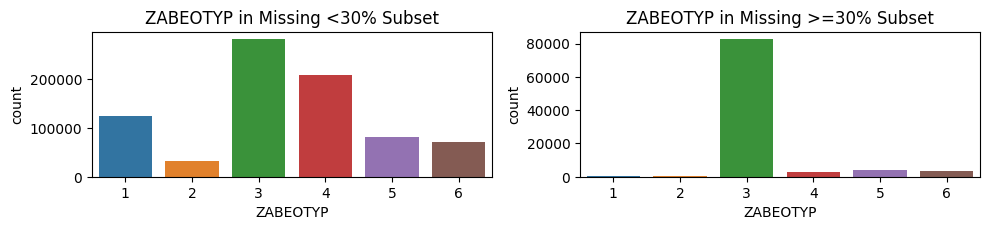

In [20]:
fig = plt.figure(figsize=(10, 4), tight_layout=True)

ax_1 = fig.add_subplot(221)
ax_1.set_title('ZABEOTYP in Missing <30% Subset')
sns.countplot(x ='ZABEOTYP', data = azdias_subset_missing_less)

ax_2 = fig.add_subplot(222)
ax_2.set_title('ZABEOTYP in Missing >=30% Subset')
sns.countplot(x ='ZABEOTYP', data = azdias_subset_missing_more);

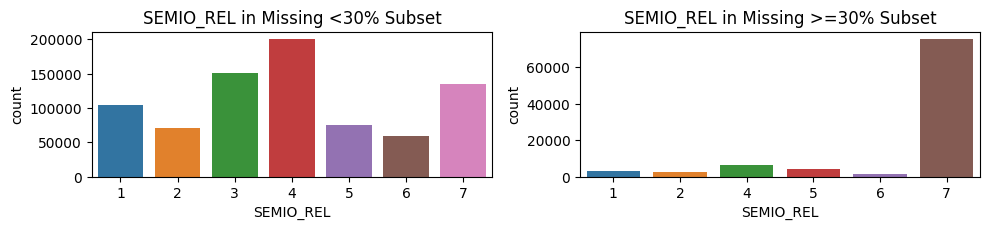

In [21]:
fig = plt.figure(figsize=(10, 4), tight_layout=True)

ax_1 = fig.add_subplot(221)
ax_1.set_title('SEMIO_REL in Missing <30% Subset')
sns.countplot(x ='SEMIO_REL', data = azdias_subset_missing_less.sort_values(by='SEMIO_REL', ascending=True))

ax_2 = fig.add_subplot(222)
ax_2.set_title('SEMIO_REL in Missing >=30% Subset')
sns.countplot(x ='SEMIO_REL', data = azdias_subset_missing_more.sort_values(by='SEMIO_REL', ascending=True));

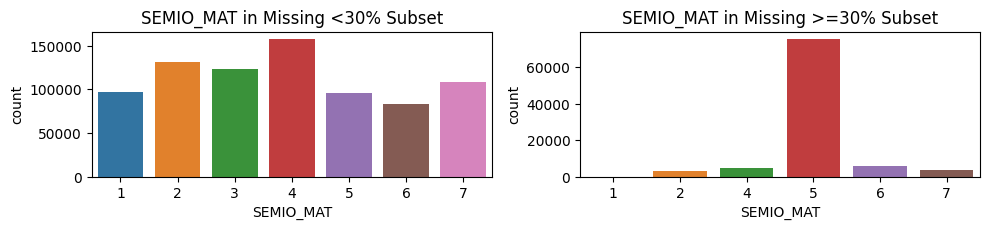

In [22]:
fig = plt.figure(figsize=(10, 4), tight_layout=True)

ax_1 = fig.add_subplot(221)
ax_1.set_title('SEMIO_MAT in Missing <30% Subset')
sns.countplot(x ='SEMIO_MAT', data = azdias_subset_missing_less)

ax_2 = fig.add_subplot(222)
ax_2.set_title('SEMIO_MAT in Missing >=30% Subset')
sns.countplot(x ='SEMIO_MAT', data = azdias_subset_missing_more);

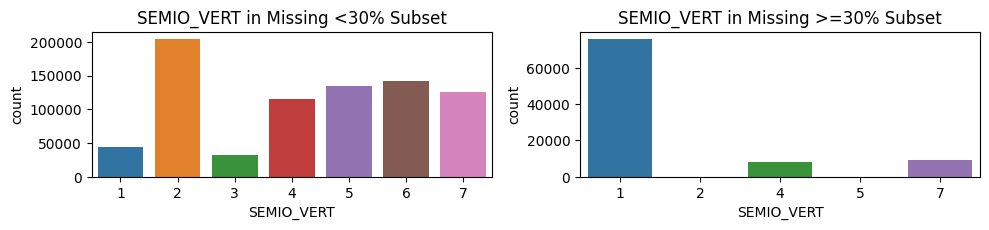

In [23]:
fig = plt.figure(figsize=(10, 4), tight_layout=True)

ax_1 = fig.add_subplot(221)
ax_1.set_title('SEMIO_VERT in Missing <30% Subset')
sns.countplot(x ='SEMIO_VERT', data = azdias_subset_missing_less)

ax_2 = fig.add_subplot(222)
ax_2.set_title('SEMIO_VERT in Missing >=30% Subset')
sns.countplot(x ='SEMIO_VERT', data = azdias_subset_missing_more);

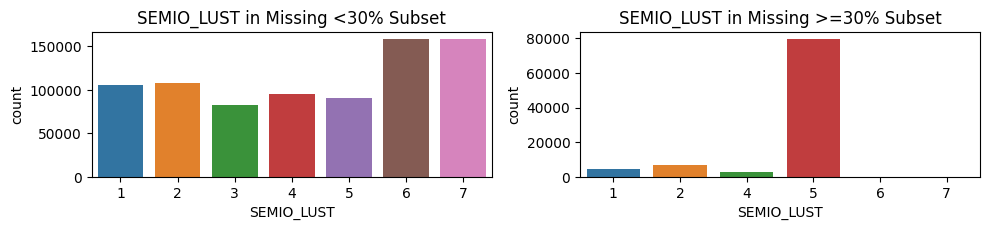

In [24]:
fig = plt.figure(figsize=(10, 4), tight_layout=True)

ax_1 = fig.add_subplot(221)
ax_1.set_title('SEMIO_LUST in Missing <30% Subset')
sns.countplot(x ='SEMIO_LUST', data = azdias_subset_missing_less)

ax_2 = fig.add_subplot(222)
ax_2.set_title('SEMIO_LUST in Missing >=30% Subset')
sns.countplot(x ='SEMIO_LUST', data = azdias_subset_missing_more);

#### Discussion 1.1.3: Assess Missing Data in Each Row  
(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows.  

***
> Response: 
> - ZABEOTYP: Value 3 is the only value that shares similar proportion between the two subsets   
> - SEMIO_REL: The proportions for all values differ between the two subsets    
> - SEMIO_MAT: The proportions for all values differ between the two subsets     
> - SEMIO_VERT: The proportions for all values differ between the two subsets     
> - SEMIO_LUST: The proportions for all values differ between the two subsets     
***

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# How many features are there of each data type?
feat_info.groupby('type')['attribute'].agg(['count']).reset_index()

,type,count
0,categorical,21
1,interval,1
2,mixed,7
3,numeric,7
4,ordinal,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

> **Results:** 
> - binary variables:
>     - ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ
> - multi-level variables:
>     - CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, SHOPPER_TYP, TITEL_KZ, ZABEOTYP, GEBAEUDETYP, CAMEO_DEUG_2015, CAMEO_DEU_2015
> - binary variable that takes on non-numeric values that needs to be re-encoded as numbers or a dummy variable:
>     - OST_WEST_KZ

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
cat_list = feat_info[feat_info['type'] == 'categorical']['attribute'].values.tolist() 
print(cat_list)

cnt = 0
for i in cat_list:
    if i in azdias_subset_missing_less.columns:
        cnt += 1
        print("\n***", cnt, "- Values for categorical column:", i, "***")
        print(azdias_subset_missing_less[i].agg(['count']).reset_index())

['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

*** 1 - Values for categorical column: ANREDE_KZ ***
   index  ANREDE_KZ
0  count     797837

*** 2 - Values for categorical column: CJT_GESAMTTYP ***
   index  CJT_GESAMTTYP
0  count         793171

*** 3 - Values for categorical column: FINANZTYP ***
   index  FINANZTYP
0  count     797837

*** 4 - Values for categorical column: GFK_URLAUBERTYP ***
   index  GFK_URLAUBERTYP
0  count           793171

*** 5 - Values for categorical column: GREEN_AVANTGARDE ***
   index  GREEN_AVANTGARDE
0  count            797837

*** 6 - Values for categorical column: LP_FAMILIE_FEIN ***
   index  LP_FAMILIE_FEIN
0  count           766539

*** 7 - Values for categorical c

In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.

# binary variable that takes on non-numeric values that needs to be re-encoded as numbers or a dummy variable: OST_WEST_KZ
azdias_subset_missing_less['OST_WEST_KZ'] = azdias_subset_missing_less['OST_WEST_KZ'].replace('O', 0) 
azdias_subset_missing_less['OST_WEST_KZ'] = azdias_subset_missing_less['OST_WEST_KZ'].replace('W', 1) 
azdias_subset_missing_less['OST_WEST_KZ'].head(100)

# multi-level variables: drop from analysis
multi_level_cols = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',  
                    'LP_STATUS_GROB', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
azdias_subset_missing_less.drop(multi_level_cols, axis=1)
azdias_subset_missing_less.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,1,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,1,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,1,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,1,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,1,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features
(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

***
> Response: 
> - I found that the column OST_WEST_KZ was the binary variable with non-numerical categories. I re-encoded this variable by replacing O/W values with 0/1 values.
> - I dropped the following multi-level variables to keep the analysis straightforward for the first pass:
>    - 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',  'LP_STATUS_GROB', 'SHOPPER_TYP', 'TITEL_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'
***





#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

**Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.** 

> PRAEGENDE_JUGENDJAHRE  
> Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)  
> - -1: unknown
> -  0: unknown
> -  1: 40s - war years (Mainstream, E+W)
> -  2: 40s - reconstruction years (Avantgarde, E+W)
> -  3: 50s - economic miracle (Mainstream, E+W)
> -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
> -  5: 60s - economic miracle (Mainstream, E+W)
> -  6: 60s - generation 68 / student protestors (Avantgarde, W)
> -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
> -  8: 70s - family orientation (Mainstream, E+W)
> -  9: 70s - peace movement (Avantgarde, E+W)
> - 10: 80s - Generation Golf (Mainstream, W)
> - 11: 80s - ecological awareness (Avantgarde, W)
> - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
> - 13: 80s - Swords into ploughshares (Avantgarde, E)
> - 14: 90s - digital media kids (Mainstream, E+W)
> - 15: 90s - ecological awareness (Avantgarde, E+W)

In [28]:
# PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). 
# While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: 
#     an interval-type variable for decade, 
#     and a binary variable for movement.

print(azdias_subset_missing_less['PRAEGENDE_JUGENDJAHRE'].agg(['count']).reset_index())

# binary movement variable
mainstream = [1,3,5,8,10,12,14]
avantgarde = [2,4,6,7,9,11,13,15]
azdias_subset_missing_less['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = np.where(azdias_subset_missing_less['PRAEGENDE_JUGENDJAHRE'].isin(mainstream), 0, 
                                                                np.where(azdias_subset_missing_less['PRAEGENDE_JUGENDJAHRE'].isin(avantgarde), 1, None))

# interval-type decade variable
azdias_subset_missing_less['PRAEGENDE_JUGENDJAHRE_DECADE'] = np.where(azdias_subset_missing_less['PRAEGENDE_JUGENDJAHRE'].isin([1,2]), 4, 
                                                                np.where(azdias_subset_missing_less['PRAEGENDE_JUGENDJAHRE'].isin([3,4]), 5,      
                                                                np.where(azdias_subset_missing_less['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]), 6, 
                                                                np.where(azdias_subset_missing_less['PRAEGENDE_JUGENDJAHRE'].isin([8,9]), 7, 
                                                                np.where(azdias_subset_missing_less['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]), 8, 
                                                                np.where(azdias_subset_missing_less['PRAEGENDE_JUGENDJAHRE'].isin([14,15]), 9, None)))))) 

display(azdias_subset_missing_less[['PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_MOVEMENT','PRAEGENDE_JUGENDJAHRE_DECADE']].head())

   index  PRAEGENDE_JUGENDJAHRE
0  count                 769164


,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE
1,14.0,0,9
2,15.0,1,9
3,8.0,0,7
4,8.0,0,7
5,3.0,0,5


**Investigate "CAMEO_INTL_2015" and engineer two new variables.**   
> 4.3. CAMEO_INTL_2015  
> German CAMEO: Wealth / Life Stage Typology, mapped to international code  
> - -1: unknown
> - 11: Wealthy Households - Pre-Family Couples & Singles
> - 12: Wealthy Households - Young Couples With Children
> - 13: Wealthy Households - Families With School Age Children
> - 14: Wealthy Households - Older Families &  Mature Couples
> - 15: Wealthy Households - Elders In Retirement
> - 21: Prosperous Households - Pre-Family Couples & Singles
> - 22: Prosperous Households - Young Couples With Children
> - 23: Prosperous Households - Families With School Age Children
> - 24: Prosperous Households - Older Families & Mature Couples
> - 25: Prosperous Households - Elders In Retirement
> - 31: Comfortable Households - Pre-Family Couples & Singles
> - 32: Comfortable Households - Young Couples With Children
> - 33: Comfortable Households - Families With School Age Children
> - 34: Comfortable Households - Older Families & Mature Couples
> - 35: Comfortable Households - Elders In Retirement
> - 41: Less Affluent Households - Pre-Family Couples & Singles
> - 42: Less Affluent Households - Young Couples With Children
> - 43: Less Affluent Households - Families With School Age Children
> - 44: Less Affluent Households - Older Families & Mature Couples
> - 45: Less Affluent Households - Elders In Retirement
> - 51: Poorer Households - Pre-Family Couples & Singles
> - 52: Poorer Households - Young Couples With Children
> - 53: Poorer Households - Families With School Age Children
> - 54: Poorer Households - Older Families & Mature Couples
> - 55: Poorer Households - Elders In Retirement
> - XX: unknown

In [29]:
# "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. 
# Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables 
# (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

print(azdias_subset_missing_less['CAMEO_INTL_2015'].agg(['count']).reset_index())

lst = ['11','12','13','14','15','21','22','23','24','25','31','32','33',
       '34','35','41','42','43','44','45','51','52','53','54','55']

# 'tens'-place digit variable
azdias_subset_missing_less['CAMEO_INTL_2015_TEN'] = np.where(azdias_subset_missing_less['CAMEO_INTL_2015'].isin(lst), 
                                                               azdias_subset_missing_less['CAMEO_INTL_2015'].astype(float) / 10, 
                                                               0).astype(int)

# 'ones'-place digit variable
azdias_subset_missing_less['CAMEO_INTL_2015_ONE'] = np.where(azdias_subset_missing_less['CAMEO_INTL_2015'].isin(lst), 
                                                               azdias_subset_missing_less['CAMEO_INTL_2015'].astype(float) % 10, 
                                                               0).astype(int)

display(azdias_subset_missing_less[['CAMEO_INTL_2015','CAMEO_INTL_2015_TEN','CAMEO_INTL_2015_ONE']].head())

   index  CAMEO_INTL_2015
0  count           791768


,CAMEO_INTL_2015,CAMEO_INTL_2015_TEN,CAMEO_INTL_2015_ONE
1,51,5,1
2,24,2,4
3,12,1,2
4,43,4,3
5,54,5,4


#### Discussion 1.2.2: Engineer Mixed-Type Features
(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

***
> Response:  

> - The variable PRAEGENDE_JUGENDJAHRE contains two categories for the dominating movement of person's youth (avantgarde vs. mainstream; east vs. west). I engineered this field into two new variables:  
>     - PRAEGENDE_JUGENDJAHRE_MOVEMENT - avantgarde or mainstream  
>     - PRAEGENDE_JUGENDJAHRE_DECADE - decade from 1940-1990  
  
> - The variable CAMEO_INTL_2015 contains two categories for the Wealth and Life Stage. I engineered this field into two new variables:  
>     - CAMEO_INTL_2015_TEN - tens'-place digit  
>     - CAMEO_INTL_2015_ONE - ones'-place digit  
***

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [31]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# columns to keep
col_list = azdias_subset_missing_less.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_DEU_2015'], axis=1).columns
print(col_list)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP',
       'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR',
       'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'KBA05_ANTG1',
       'KBA05_ANTG2', '

In [32]:
# new df with specified columns
azdias_subset_missing_less = azdias_subset_missing_less[col_list]
azdias_subset_missing_less.info()
azdias_subset_missing_less.head()

<class 'pandas.core.frame.DataFrame'>
Index: 797837 entries, 1 to 891220
Data columns (total 80 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ALTERSKATEGORIE_GROB            795037 non-null  float64
 1   ANREDE_KZ                       797837 non-null  int64  
 2   CJT_GESAMTTYP                   793171 non-null  float64
 3   FINANZ_MINIMALIST               797837 non-null  int64  
 4   FINANZ_SPARER                   797837 non-null  int64  
 5   FINANZ_VORSORGER                797837 non-null  int64  
 6   FINANZ_ANLEGER                  797837 non-null  int64  
 7   FINANZ_UNAUFFAELLIGER           797837 non-null  int64  
 8   FINANZ_HAUSBAUER                797837 non-null  int64  
 9   FINANZTYP                       797837 non-null  int64  
 10  GFK_URLAUBERTYP                 793171 non-null  float64
 11  GREEN_AVANTGARDE                797837 non-null  int64  
 12  HEALTH_TYP           

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_TEN,CAMEO_INTL_2015_ONE
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,1,4.0,8,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,9,5,1
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,1,2.0,4,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1,9,2,4
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,1,7.0,2,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,7,1,2
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,1,3.0,6,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,7,4,3
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,1,7.0,8,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,5,5,4


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [33]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
 
    # convert missing value codes into NaNs, ...
    # ie where value in missing_or_unknown_list change value to NaN 
    for i in range(len(feat_info)):
        # using regex to extract the digits
        missing_df = re.sub('[\[|\]]', '',feat_info.iloc[i]['missing_or_unknown']).split(',')
        # return the digit values for integer strings only
        if missing_df != ['']:
            missing_df = [np.int64(data) if (data!='X' and data!='XX') else data for data in missing_df]
            df = df.replace({feat_info.iloc[i]['attribute']: missing_df}, np.nan)

    # remove selected columns and rows, ...
    
    # remove the outlier columns from the dataset
    outliers = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    df_minus_outliers = df.drop(outliers, axis=1) 

    # select, re-encode, and engineer column values, ...
    
    # OST_WEST_KZ: binary variable that takes on non-numeric values that needs 
    # to be re-encoded as numbers or a dummy variable: 
    df_minus_outliers['OST_WEST_KZ'] = df_minus_outliers['OST_WEST_KZ'].replace('O', 0) 
    df_minus_outliers['OST_WEST_KZ'] = df_minus_outliers['OST_WEST_KZ'].replace('W', 1) 

    # multi-level variables: drop from analysis
    multi_level_cols = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',  
                        'LP_STATUS_GROB', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    df_minus_outliers.drop(multi_level_cols, axis=1)

    # PRAEGENDE_JUGENDJAHRE: create variables for movement and decade  
    # binary movement variable
    mainstream = [1,3,5,8,10,12,14]
    avantgarde = [2,4,6,7,9,11,13,15]
    df_minus_outliers['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = np.where(df_minus_outliers['PRAEGENDE_JUGENDJAHRE'].isin(mainstream), 0, 
                                                                np.where(df_minus_outliers['PRAEGENDE_JUGENDJAHRE'].isin(avantgarde), 1, None))
    # interval-type decade variable
    df_minus_outliers['PRAEGENDE_JUGENDJAHRE_DECADE'] = np.where(df_minus_outliers['PRAEGENDE_JUGENDJAHRE'].isin([1,2]), 4, 
                                                                np.where(df_minus_outliers['PRAEGENDE_JUGENDJAHRE'].isin([3,4]), 5,      
                                                                np.where(df_minus_outliers['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]), 6, 
                                                                np.where(df_minus_outliers['PRAEGENDE_JUGENDJAHRE'].isin([8,9]), 7, 
                                                                np.where(df_minus_outliers['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]), 8, 
                                                                np.where(df_minus_outliers['PRAEGENDE_JUGENDJAHRE'].isin([14,15]), 9, None)))))) 

    # CAMEO_INTL_2015: 'tens'-place and 'ones'-place digits into two new ordinal variables 
    lst = ['11','12','13','14','15','21','22','23','24','25','31','32','33',
           '34','35','41','42','43','44','45','51','52','53','54','55']
    
    # 'tens'-place digit variable
    df_minus_outliers['CAMEO_INTL_2015_TEN'] = np.where(df_minus_outliers['CAMEO_INTL_2015'].isin(lst), 
                                                               df_minus_outliers['CAMEO_INTL_2015'].astype(float) / 10, 
                                                               0).astype(int)
    # 'ones'-place digit variable
    df_minus_outliers['CAMEO_INTL_2015_ONE'] = np.where(df_minus_outliers['CAMEO_INTL_2015'].isin(lst), 
                                                               df_minus_outliers['CAMEO_INTL_2015'].astype(float) % 10, 
                                                               0).astype(int)

    # columns to keep
    df_cleaned = df_minus_outliers.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_DEU_2015'], axis=1)

    # Return the cleaned dataframe...
    return df_cleaned
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [34]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.

# replace none's with nan's
azdias_subset_missing_less = azdias_subset_missing_less.fillna(value=np.nan)

# impute nan's with most frequent value
# create imputer
imp = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

#fit imputer to azdias data
azdias_imp_fit = imp.fit(azdias_subset_missing_less)

# transform to impute nan's
azdias_imp_trans = azdias_imp_fit.transform(azdias_subset_missing_less)

# convert to df
azdias_imp_df = pd.DataFrame(azdias_imp_trans, columns=list(azdias_subset_missing_less))
display(azdias_imp_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797837 entries, 0 to 797836
Data columns (total 80 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   ALTERSKATEGORIE_GROB            797837 non-null  object
 1   ANREDE_KZ                       797837 non-null  object
 2   CJT_GESAMTTYP                   797837 non-null  object
 3   FINANZ_MINIMALIST               797837 non-null  object
 4   FINANZ_SPARER                   797837 non-null  object
 5   FINANZ_VORSORGER                797837 non-null  object
 6   FINANZ_ANLEGER                  797837 non-null  object
 7   FINANZ_UNAUFFAELLIGER           797837 non-null  object
 8   FINANZ_HAUSBAUER                797837 non-null  object
 9   FINANZTYP                       797837 non-null  object
 10  GFK_URLAUBERTYP                 797837 non-null  object
 11  GREEN_AVANTGARDE                797837 non-null  object
 12  HEALTH_TYP                    

None

In [35]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imp_trans)

### Discussion 2.1: Apply Feature Scaling
(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

***
> Response:  
> - I chose to use the sklearn SimpleImputer with "most frequent" strategy to fill missing values with the most frequent value. I used most frequent as opposed to the mean, because as the values relate to categories the mean would not make sense.   
> - I then used the sklearn StandardScaler on the imputed dataset which scales each fetaure to mean 0 and standard deviation 1.  
***

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [36]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit(azdias_scaled)

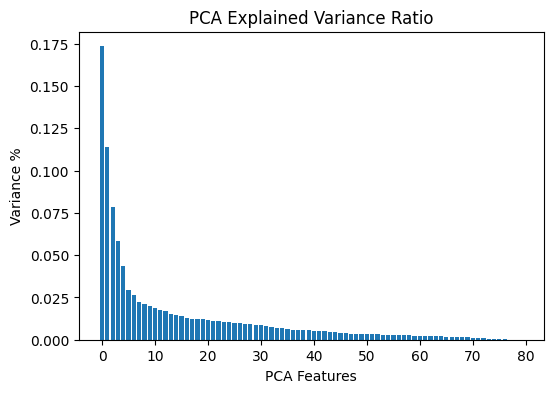

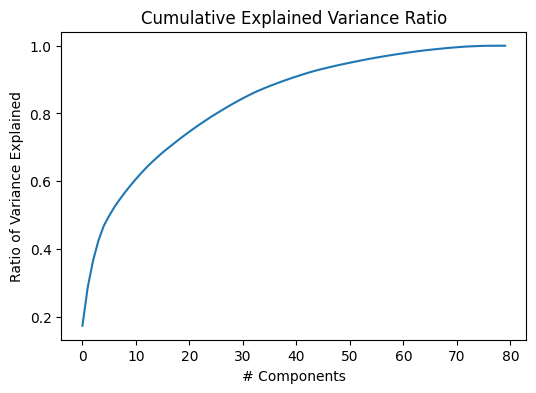

In [37]:
# Investigate the variance accounted for by each principal component.

# get the pca explained variance ratios
var = pca.explained_variance_ratio_
#print("Explained Variance Ratio:\n", var)
plt.figure(figsize=(6, 4))
plt.bar(list(range(var.shape[0])), var)
plt.xlabel('PCA Features')
plt.ylabel('Variance %')
plt.title('PCA Explained Variance Ratio')
plt.xticks()
plt.show();

# get the cumulative pca explained variance ratios
cumsum = np.cumsum(var)
#print("Cumulative Explained Variance Ratio:\n", cumsum)
plt.figure(figsize=(6, 4))
plt.plot(range(var.shape[0]), cumsum)
plt.xlabel("# Components")
plt.ylabel("Ratio of Variance Explained")
plt.title('Cumulative Explained Variance Ratio')
plt.xticks()
plt.show();

In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components = 30)
azdias_pca = pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction
(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)  

************
> Response:     
> - I chose to retain 30 principal components which explained around 80% of the variance as shown in the Cumulative Explained Variance Ratio chart.   
>     
************


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
def pca_weights(full_dataset, pca, i):
    '''
    Function to print the sorted list of feature weights, for the i-th principal component
    Create a DataFrame of the PCA results mapped to full dataset columns
    Print the sorted list of feature weights for the i-th principal component
    '''    
    components = pca.components_
    df = pd.DataFrame(components, columns=list(full_dataset.columns))
    
    n = i - 1
    
    if (n >= 0) and (n < len(components)):    
        weights = df.iloc[n].sort_values(ascending=False)
        return weights        
    else: 
        return "Error: i was out of bounds"
        

In [40]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights(azdias_imp_df, pca, 1)

PLZ8_ANTG3             0.195899
HH_EINKOMMEN_SCORE     0.192000
CAMEO_DEUG_2015        0.191566
PLZ8_ANTG4             0.189618
CAMEO_INTL_2015_TEN    0.187526
                         ...   
FINANZ_MINIMALIST     -0.193744
PLZ8_ANTG1            -0.196890
MOBI_REGIO            -0.199342
LP_STATUS_GROB        -0.213042
LP_STATUS_FEIN        -0.214937
Name: 0, Length: 80, dtype: float64

In [41]:
### Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(azdias_imp_df, pca, 2)


ALTERSKATEGORIE_GROB            0.265443
FINANZ_VORSORGER                0.238221
SEMIO_ERL                       0.223749
SEMIO_LUST                      0.183803
RETOURTYP_BK_S                  0.161720
                                  ...   
SEMIO_TRADV                    -0.232473
SEMIO_PFLICHT                  -0.235598
FINANZ_SPARER                  -0.248735
PRAEGENDE_JUGENDJAHRE_DECADE   -0.249205
SEMIO_REL                      -0.257109
Name: 1, Length: 80, dtype: float64

In [42]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(azdias_imp_df, pca, 3)


SEMIO_VERT           0.337358
SEMIO_SOZ            0.260491
SEMIO_FAM            0.254975
SEMIO_KULT           0.242750
FINANZ_MINIMALIST    0.149476
                       ...   
SEMIO_RAT           -0.199160
SEMIO_KRIT          -0.273568
SEMIO_DOM           -0.307514
SEMIO_KAEM          -0.332416
ANREDE_KZ           -0.363308
Name: 2, Length: 80, dtype: float64

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

***
> Response:  

> **1st first principal component**  
> - The 1st principal component is correlated with LP_STATUS_FEIN and LP_STATUS_GROB. As these variables decrease, the 1st principal component increases. 
>     - LP_STATUS_GROB, -0.213042
>     - LP_STATUS_FEIN, -0.214937

> **2nd principal component** 
> - The 2nd principal component is correlated with ALTERSKATEGORIE_GROB and SEMIO_REL. As ALTERSKATEGORIE_GROB increases, as does the 2nd principal component. As SEMIO_REL decreases, the 2nd prinicpal component increases.
>     - ALTERSKATEGORIE_GROB, 0.265443
>     - SEMIO_REL, -0.257109

> **3rd principal component**   
> - The 3rd principal component is correlated most strongly with ANREDE_KZ. As this variable decreases, the principal componenet increases.  
>     - ANREDE_KZ, -0.363308
    
> Reference for Interpretation of the Principal Components:   
> https://online.stat.psu.edu/stat505/lesson/11/11.4#:~:text=Interpretation%20of%20the%20principal%20components%20is%20based%20on%20finding%20which,of%20course%20a%20subjective%20decision.

---

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [43]:
scores = []
centers = list(range(1,31))
print("Scores by # of Clusters:")

# Over a number of different cluster counts...
for x in centers:

    # ...run k-means clustering on the data...   
    #instantiate kmeans
    kmeans = KMeans(n_clusters=x)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(azdias_pca)
 
    # ...compute the average within-cluster distances.
    # Obtain a score related to the model fit
    score = np.abs(model.score(azdias_pca))
    print(x, "Clusters:", score)
    scores.append([x, score])    

print(scores)

Scores by # of Clusters:
1 Clusters: 53357211.58112098
2 Clusters: 45002281.69386522
3 Clusters: 41485886.89419089
4 Clusters: 39235005.32556283
5 Clusters: 37743120.45046025
6 Clusters: 36444739.89269392
7 Clusters: 35209189.571419194
8 Clusters: 34291245.003682494
9 Clusters: 33490856.43058654
10 Clusters: 32735799.689955346
11 Clusters: 32335774.763493847
12 Clusters: 31766008.21688433
13 Clusters: 31277590.49794381
14 Clusters: 30987903.850145407
15 Clusters: 30451596.979634836
16 Clusters: 30028828.138828952
17 Clusters: 29668398.416234244
18 Clusters: 29420801.295575533
19 Clusters: 29091254.55686807
20 Clusters: 28880064.81104553
21 Clusters: 28214047.631186053
22 Clusters: 28063173.662538208
23 Clusters: 27809504.46127694
24 Clusters: 27507959.18011641
25 Clusters: 27198088.693098135
26 Clusters: 27060062.682487078
27 Clusters: 26737706.947955668
28 Clusters: 26715264.339448094
29 Clusters: 26406786.898844045
30 Clusters: 26181488.95231493
[[1, 53357211.58112098], [2, 45002281.

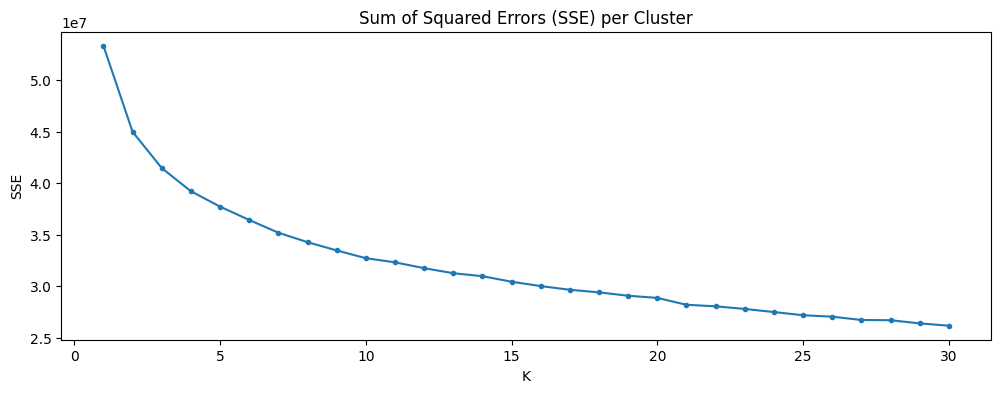

In [91]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

s = [i[1] for i in scores]

plt.figure(figsize=(12, 4))
plt.plot(centers, s, linestyle='-', marker='.')
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('Sum of Squared Errors (SSE) per Cluster');

In [45]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

clusters = 15

#instantiate kmeans
kmeans = KMeans(n_clusters=clusters)

# fit the model to the data using the fit method
model_15 = kmeans.fit(azdias_pca)

# make predictions for azdias general population
azdias_pred = model_15.predict(azdias_pca)

# compute the average within-cluster distances.
# Obtain a score related to the model fit
score = np.abs(model_15.score(azdias_pca))
print("Score for", clusters, "Clusters:", score)

Score for 15 Clusters: 30721675.394644104


### Discussion 3.1: Apply Clustering to General Population
(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

***
> Response:
> - I chose to segment the population into 15 clusters. After around 15 clusters, the SSE begins to decrease much more gradually. This point can be referred to as the elbow.     
> - Reference: https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/  
***

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [46]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [47]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)
display(customers_clean.head())

# replace none's with nan's
customers_clean = customers_clean.fillna(value=np.nan)

# impute nan's with most frequent value
cust_imp = imp.transform(customers_clean)

# Apply scaler transformation
cust_scaled = scaler.transform(cust_imp)
    
# Apply pca transformation
customers_pca = pca.transform(cust_scaled)

# Predict using Kmeans, clusters = 15
customers_pred = model_15.predict(customers_pca)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_TEN,CAMEO_INTL_2015_ONE
0,4.0,1,5.0,5,1,5,1,2,2,2,4.0,1,1.0,20.0,5.0,2.0,2.0,10.0,5.0,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3.0,0.0,1.0,3,2.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,1.0,7.0,1,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,1,5,1,3
1,4.0,1,NaN,5,1,5,1,3,2,2,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,1.0,3,3.0,0.0,NaN,NaN,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,0,0
2,4.0,2,2.0,5,1,5,1,4,4,2,3.0,1,2.0,13.0,3.0,1.0,1.0,10.0,5.0,1.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1.0,0.0,2.0,3,1.0,0.0,1.0,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,1.0,2.0,5,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,1,5,3,4
3,4.0,1,2.0,5,1,5,2,1,2,6,10.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,0.0,1.0,1,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,2.0,1992.0,1.0,7.0,4,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0,0,4,2,4
4,3.0,1,6.0,3,1,4,4,5,2,2,2.0,0,3.0,31.0,10.0,10.0,5.0,1.0,1.0,1.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1.0,0.0,2.0,1,4.0,0.0,6.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,1.0,3.0,7,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0,0,7,4,1


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [48]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
'''>>>this code did not work out, removed............
fig = plt.figure(figsize=(10, 4), tight_layout=True)
ax_1 = fig.add_subplot(221)
ax_1.set_title('Customer Data Clusters')
ax_1.xaxis.set(ticklabels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
sns.countplot(data = customers_pred)
ax_2 = fig.add_subplot(222)
ax_2.set_title('General Data Clusters')
ax_2.xaxis.set(ticklabels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
sns.countplot(data = azdias_pred)
plt.show();
'''

">>>this code did not work out, removed............\nfig = plt.figure(figsize=(10, 4), tight_layout=True)\nax_1 = fig.add_subplot(221)\nax_1.set_title('Customer Data Clusters')\nax_1.xaxis.set(ticklabels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])\nsns.countplot(data = customers_pred)\nax_2 = fig.add_subplot(222)\nax_2.set_title('General Data Clusters')\nax_2.xaxis.set(ticklabels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])\nsns.countplot(data = azdias_pred)\nplt.show();\n"

In [49]:
# code borrowed from https://github.com/jsthomp/Id-customer-segments/blob/main/Identify_Customer_Segments%20(4).ipynb

# create new df's for the predictions
gen_clust_df = pd.DataFrame(azdias_pred, columns = ['general_pop_cluster'])
cust_clust_df = pd.DataFrame(customers_pred, columns = ['customers_cluster'])

# find the value counts by cluster
cluster_predict_general = pd.Series(azdias_pred).value_counts().sort_index()
cluster_predict_customers = pd.Series(customers_pred).value_counts().sort_index()

# combine azdias and customer predictions into a new df: df_predictions
df_predictions = pd.concat([cluster_predict_general, cluster_predict_customers], axis=1).reset_index()
df_predictions.columns = ['cluster', 'general_pop', 'customer_pop']

# adding new columns to df_predictions of percentages of general and customer
df_predictions['general%'] = (df_predictions['general_pop'] / df_predictions['general_pop'].sum()*100).round(0)
df_predictions['customer%'] = (df_predictions['customer_pop'] / df_predictions['customer_pop'].sum()*100).round(0)
display(df_predictions.head())

,cluster,general_pop,customer_pop,general%,customer%
0,0,50946,6514,6.0,3.0
1,1,43636,5010,5.0,3.0
2,2,57551,13359,7.0,7.0
3,3,75751,13448,9.0,7.0
4,4,69640,1153,9.0,1.0


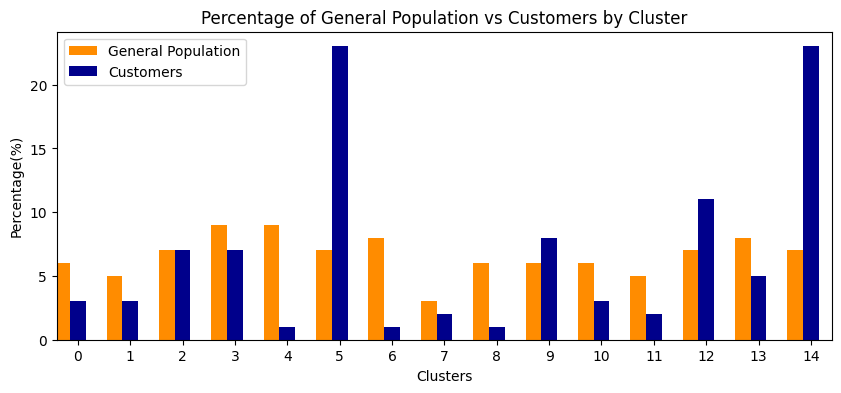

In [50]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# plot the general population and customer data by cluster 

fig = plt.figure(figsize=(10,4))

ax = df_predictions['general%'].plot(x=df_predictions['cluster'], kind='bar', color='darkorange', width=-0.3, align='edge', position=0)
ax = df_predictions['customer%'].plot(x=df_predictions['cluster'], kind='bar', color='darkblue', width=0.3, align='edge', position=1)

ax.set_xlabel('Clusters') 
ax.set_ylabel('Percentage(%)') 
plt.xticks(rotation=360,)
plt.legend(('General Population', 'Customers')) 
plt.title('Percentage of General Population vs Customers by Cluster') 
plt.show();

In [87]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Reference: https://knowledge.udacity.com/questions/906309

# Note: cluster 5 is overrepresented in the customer data compared to the general population
extracted_data_5 = scaler.inverse_transform(np.dot(customers_pca, pca.components_))[np.where(customers_pred==5)]
extracted_data_5 = pd.DataFrame(extracted_data, columns=azdias_imp_df.columns)
extracted_data_5.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_TEN,CAMEO_INTL_2015_ONE
0,4.223651,0.931714,4.493755,5.015395,1.003293,4.879694,0.666153,2.354973,2.218776,3.612589,3.904886,1.074595,1.107645,16.951857,4.709830,2.688085,1.847227,9.246233,4.612228,1.056368,5.346588,5.721519,5.001420,2.725116,4.731288,7.447659,7.886188,4.804034,4.094790,1.619772,2.403233,1.405602,1.579100,1.975504,2.508004,2.645618,-0.001801,0.953586,1.718223,1.728748,0.003957,1.965574,5.236915,8.815338,0.022828,-0.023832,0.659030,3.676333,1993.157330,1.153145,7.694534,2.264473,2.392582,1.680500,0.093052,-0.116665,4.062595,3.514052,2.630842,4.484149,4.213711,0.811857,3.991453,3.181659,1.430207,1260.581369,2.906626,2.662292,0.918140,0.080692,0.728348,4.661578,5.089019,1.114805,2.139781,0.679954,1.074595,5.894409,1.408509,4.251497
1,3.108553,1.049474,4.002015,4.663703,0.978840,5.378796,0.915026,1.472402,2.933138,4.720439,10.919931,1.054982,3.047362,16.637311,4.771059,2.887001,1.920019,7.210601,3.803847,1.024432,3.027337,5.845105,4.835878,3.547182,2.584156,5.800649,4.956507,4.029317,4.682433,2.318753,3.605942,4.461118,2.733475,3.349453,2.632109,1.217979,-0.001449,2.155272,1.671457,1.679709,0.002735,2.721061,5.686138,8.909669,0.730077,-0.010265,0.935006,2.144059,1991.640589,1.076802,0.203614,4.169727,1.928619,1.400174,1.042789,0.043716,3.174932,6.813380,4.079140,6.856006,3.720589,2.049590,3.242214,2.888241,3.236273,1104.765472,2.327179,3.537087,2.085334,0.763712,1.354637,5.241183,4.877719,3.626259,5.888443,4.324814,1.054982,5.762182,2.609090,3.898667
2,3.263634,1.208334,2.509157,5.152274,0.748226,5.498481,1.335280,1.633589,2.584103,3.535426,10.254228,0.987182,1.207747,19.152409,5.282892,2.950587,1.939703,10.491957,5.002979,0.961708,4.496004,4.966822,4.151120,3.543440,2.014258,5.828151,4.229689,3.915807,4.146644,2.368260,2.615505,1.822353,2.248172,2.785009,2.814672,0.361825,-0.000021,1.458661,0.892709,1.771680,0.002870,1.935279,5.609287,8.712797,-0.331466,-0.009056,0.985477,3.808209,1992.586246,1.078224,7.148990,3.404914,3.257652,0.494866,-0.110271,-0.017822,4.503279,5.024779,2.316993,5.542705,4.003833,2.061498,4.647402,2.627983,2.926331,1247.208621,3.082530,2.208152,0.801800,0.219935,0.846984,4.923675,5.259582,1.983743,2.461021,1.935187,0.987182,5.467729,1.920357,3.229855
3,4.147261,0.875953,2.146057,5.323169,0.679476,4.760786,0.192361,1.926958,2.179772,4.570872,7.944665,1.077566,1.304644,18.528300,5.124231,2.968568,1.957636,9.211647,4.670634,0.974146,4.341335,5.898690,5.101562,2.692631,4.979006,7.671589,7.377985,4.636511,4.475315,1.754773,2.583406,2.568466,1.733718,1.842835,2.796025,2.552709,-0.000075,0.928065,2.265097,1.613075,0.001777,2.099135,5.204762,8.896754,-0.479206,0.006640,0.920519,3.308760,1992.332593,0.936759,3.418492,1.375915,2.791218,1.572936,-0.152581,-0.052612,4.220686,4.853044,3.540127,5.317793,3.945290,0.925747,4.269587,2.228389,1.251111,467.739537,2.597869,2.946526,1.289644,0.360690,1.414815,2.961738,3.281130,2.714619,4.388251,2.955618,1.077566,5.591418,1.026710,5

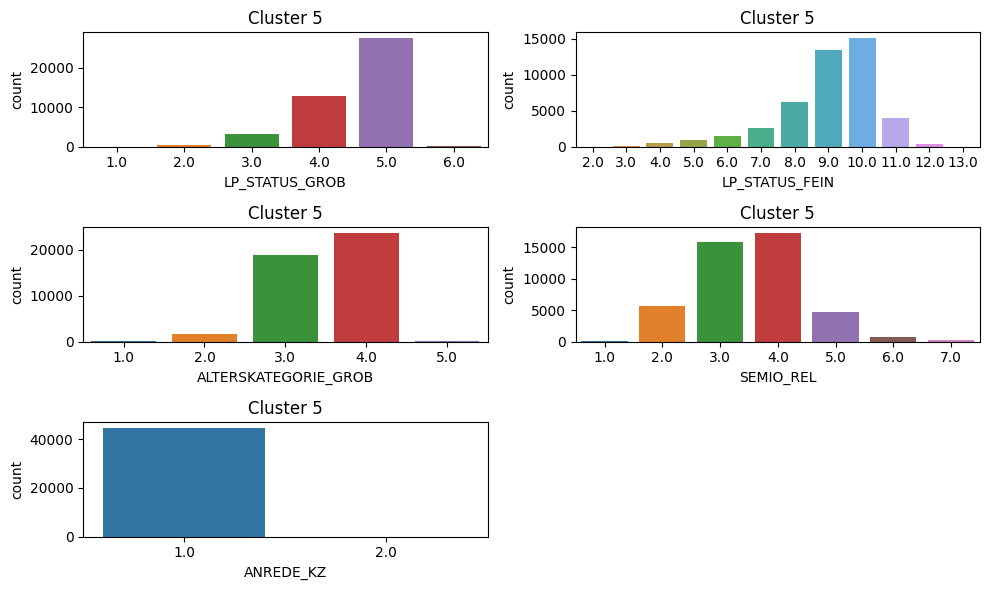

In [88]:
# get the prominent columns from pca interpretation in step 2.3, rounded since the inverse transformation left decimals
plotdata_5 = extracted_data_5[['LP_STATUS_GROB', 'LP_STATUS_FEIN', 'ALTERSKATEGORIE_GROB', 'SEMIO_REL', 'ANREDE_KZ']].round(0)
 
# plot the column values    
fig = plt.figure(figsize=(10, 6), tight_layout=True)

ax_1 = fig.add_subplot(321)
ax_1.set_title('Cluster 5')
sns.countplot(x ='LP_STATUS_GROB', data = plotdata_5)

ax_2 = fig.add_subplot(322)
ax_2.set_title('Cluster 5')
sns.countplot(x ='LP_STATUS_FEIN', data = plotdata_5)

ax_3 = fig.add_subplot(323)
ax_3.set_title('Cluster 5')
sns.countplot(x ='ALTERSKATEGORIE_GROB', data = plotdata_5)

ax_4 = fig.add_subplot(324)
ax_4.set_title('Cluster 5')
sns.countplot(x ='SEMIO_REL', data = plotdata_5)

ax_5 = fig.add_subplot(325)
ax_5.set_title('Cluster 5')
sns.countplot(x ='ANREDE_KZ', data = plotdata_5);

In [89]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Reference: https://knowledge.udacity.com/questions/906309

# Note: cluster 4 is underrepresented in the customer data compared to the general population
extracted_data_4 = scaler.inverse_transform(np.dot(customers_pca, pca.components_))[np.where(customers_pred==4)]
extracted_data_4 = pd.DataFrame(extracted_data, columns=azdias_imp_df.columns)
extracted_data_4.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_TEN,CAMEO_INTL_2015_ONE
0,4.223651,0.931714,4.493755,5.015395,1.003293,4.879694,0.666153,2.354973,2.218776,3.612589,3.904886,1.074595,1.107645,16.951857,4.709830,2.688085,1.847227,9.246233,4.612228,1.056368,5.346588,5.721519,5.001420,2.725116,4.731288,7.447659,7.886188,4.804034,4.094790,1.619772,2.403233,1.405602,1.579100,1.975504,2.508004,2.645618,-0.001801,0.953586,1.718223,1.728748,0.003957,1.965574,5.236915,8.815338,0.022828,-0.023832,0.659030,3.676333,1993.157330,1.153145,7.694534,2.264473,2.392582,1.680500,0.093052,-0.116665,4.062595,3.514052,2.630842,4.484149,4.213711,0.811857,3.991453,3.181659,1.430207,1260.581369,2.906626,2.662292,0.918140,0.080692,0.728348,4.661578,5.089019,1.114805,2.139781,0.679954,1.074595,5.894409,1.408509,4.251497
1,3.108553,1.049474,4.002015,4.663703,0.978840,5.378796,0.915026,1.472402,2.933138,4.720439,10.919931,1.054982,3.047362,16.637311,4.771059,2.887001,1.920019,7.210601,3.803847,1.024432,3.027337,5.845105,4.835878,3.547182,2.584156,5.800649,4.956507,4.029317,4.682433,2.318753,3.605942,4.461118,2.733475,3.349453,2.632109,1.217979,-0.001449,2.155272,1.671457,1.679709,0.002735,2.721061,5.686138,8.909669,0.730077,-0.010265,0.935006,2.144059,1991.640589,1.076802,0.203614,4.169727,1.928619,1.400174,1.042789,0.043716,3.174932,6.813380,4.079140,6.856006,3.720589,2.049590,3.242214,2.888241,3.236273,1104.765472,2.327179,3.537087,2.085334,0.763712,1.354637,5.241183,4.877719,3.626259,5.888443,4.324814,1.054982,5.762182,2.609090,3.898667
2,3.263634,1.208334,2.509157,5.152274,0.748226,5.498481,1.335280,1.633589,2.584103,3.535426,10.254228,0.987182,1.207747,19.152409,5.282892,2.950587,1.939703,10.491957,5.002979,0.961708,4.496004,4.966822,4.151120,3.543440,2.014258,5.828151,4.229689,3.915807,4.146644,2.368260,2.615505,1.822353,2.248172,2.785009,2.814672,0.361825,-0.000021,1.458661,0.892709,1.771680,0.002870,1.935279,5.609287,8.712797,-0.331466,-0.009056,0.985477,3.808209,1992.586246,1.078224,7.148990,3.404914,3.257652,0.494866,-0.110271,-0.017822,4.503279,5.024779,2.316993,5.542705,4.003833,2.061498,4.647402,2.627983,2.926331,1247.208621,3.082530,2.208152,0.801800,0.219935,0.846984,4.923675,5.259582,1.983743,2.461021,1.935187,0.987182,5.467729,1.920357,3.229855
3,4.147261,0.875953,2.146057,5.323169,0.679476,4.760786,0.192361,1.926958,2.179772,4.570872,7.944665,1.077566,1.304644,18.528300,5.124231,2.968568,1.957636,9.211647,4.670634,0.974146,4.341335,5.898690,5.101562,2.692631,4.979006,7.671589,7.377985,4.636511,4.475315,1.754773,2.583406,2.568466,1.733718,1.842835,2.796025,2.552709,-0.000075,0.928065,2.265097,1.613075,0.001777,2.099135,5.204762,8.896754,-0.479206,0.006640,0.920519,3.308760,1992.332593,0.936759,3.418492,1.375915,2.791218,1.572936,-0.152581,-0.052612,4.220686,4.853044,3.540127,5.317793,3.945290,0.925747,4.269587,2.228389,1.251111,467.739537,2.597869,2.946526,1.289644,0.360690,1.414815,2.961738,3.281130,2.714619,4.388251,2.955618,1.077566,5.591418,1.026710,5

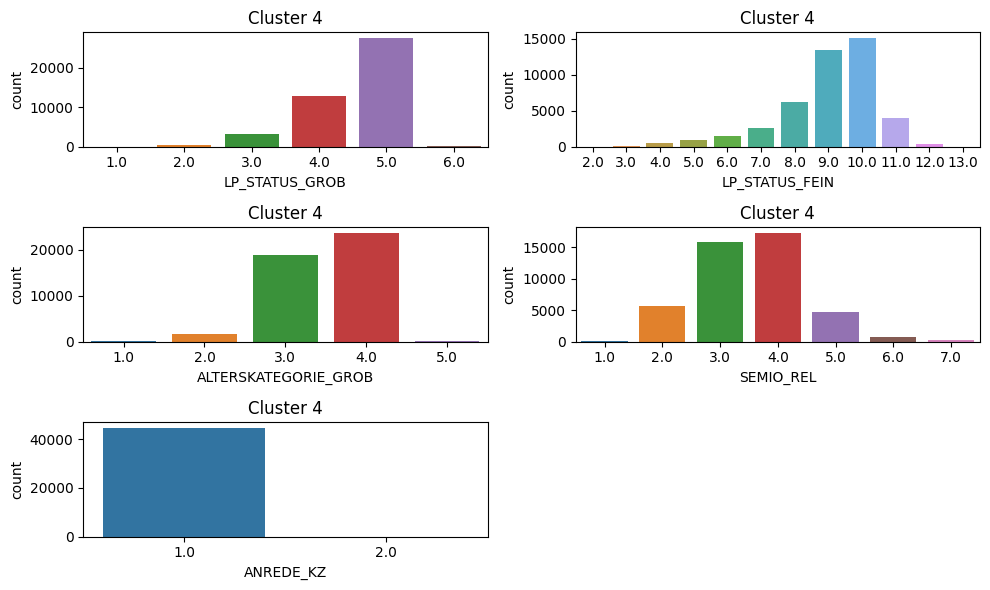

In [90]:
# get the prominent columns from above, rounded since the inverse transform left decimals
plotdata_4 = extracted_data_4[['LP_STATUS_GROB', 'LP_STATUS_FEIN', 'ALTERSKATEGORIE_GROB', 'SEMIO_REL', 'ANREDE_KZ']].round(0)
 
# plot the column values    
fig = plt.figure(figsize=(10, 6), tight_layout=True)

ax_1 = fig.add_subplot(321)
ax_1.set_title('Cluster 4')
sns.countplot(x ='LP_STATUS_GROB', data = plotdata_4)

ax_2 = fig.add_subplot(322)
ax_2.set_title('Cluster 4')
sns.countplot(x ='LP_STATUS_FEIN', data = plotdata_4)

ax_3 = fig.add_subplot(323)
ax_3.set_title('Cluster 4')
sns.countplot(x ='ALTERSKATEGORIE_GROB', data = plotdata_4)

ax_4 = fig.add_subplot(324)
ax_4.set_title('Cluster 4')
sns.countplot(x ='SEMIO_REL', data = plotdata_4)

ax_5 = fig.add_subplot(325)
ax_5.set_title('Cluster 4')
sns.countplot(x ='ANREDE_KZ', data = plotdata_4);

### Discussion 3.3: Compare Customer Data to Demographics Data
(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

***
> Response:
>
> - Cluster 5 is overrepresented in the customer data compared to the general population.  
> - Cluster 4 is underrepresented in the customer data compared to the general population.  
> - Both clusters 4 and 5 resulted in similar outcomes for the prominent features: 'LP_STATUS_GROB', 'LP_STATUS_FEIN', 'ALTERSKATEGORIE_GROB', 'SEMIO_REL', 'ANREDE_KZ'  
>
> - Referencing the definitions for the variables below, we can discern the following information from the bar charts related to the populations considered most and least popular with the mail-order company: 
>    - The mail-order company is most popular with males over 60 years old with an average affinity personality typology, who are houseowners or top earners.
>    - The mail-order company is least popular with females younger than 30 years old with the highest affinity personality typology, who are low-income earners.
***



> **Prominent Principal Components from Discussion 2.3: Interpret Principal Components**  

> **1st first principal component**  
> - LP_STATUS_GROB  
>        - Definition: Social status, rough scale  
>            - 1: low-income earners (maps to 1-2 in fine scale)  
>            - 2: average earners (maps to 3-5 in fine scale)  
>            - 3: independents (maps to 6-7 in fine scale)  
>            - 4: houseowners (maps to 8-9 in fine scale)  
>            - 5: top earners (maps to 10 in fine scale)  
> - LP_STATUS_FEIN   
>        - Definition: Social status, fine scale  
>            -  1: typical low-income earners  
>            -  2: orientation-seeking low-income earners  
>            -  3: aspiring low-income earners  
>            -  4: villagers  
>            -  5: minimalistic high-income earners  
>            -  6: independent workers  
>            -  7: title holder-households  
>            -  8: new houseowners  
>            -  9: houseowners  
>            - 10: top earners  

> **2nd principal component** 
> - ALTERSKATEGORIE_GROB  
>        - Definition: Estimated age based on given name analysis  
>            - -1: unknown (missing)  
>            -  0: unknown (cannot be determined)  
>            -  1: < 30 years old  
>            -  2: 30 - 45 years old  
>            -  3: 46 - 60 years old  
>            -  4: > 60 years old  
>            -  9: uniformly distributed  

> - SEMIO_REL  
>        - Definition: Personality typology, for each dimension:  
>            - -1: unknown  
>            -  1: highest affinity  
>            -  2: very high affinity  
>            -  3: high affinity  
>            -  4: average affinity  
>            -  5: low affinity  
>            -  6: very low affinity  
>            -  7: lowest affinity  
>            -  9: unknown  
>               - Dimension translations:  
>                  - SOZ: socially-minded  
>                  - FAM: family-minded  
>                  - REL: religious  
>                  - MAT: materialistic  
>                  - VERT: dreamful  
>                  - LUST: sensual-minded  
>                  - ERL: event-oriented  
>                  - KULT: cultural-minded  
>                  - RAT: rational  
>                  - KRIT: critical-minded  
>                  - DOM: dominant-minded  
>                  - KAEM: combative attitude  
>                  - PFLICHT: dutiful  
>                  - TRADV: tradional-minded  

> **3rd principal component**     
> - ANREDE_KZ   
>        - Definition: Gender  
>            - -1: unknown (missing)  
>            -  0: unknown (cannot be determined)  
>            -  1: male  
>            -  2: female  

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.